# Coursera Capstone Notebook


#### Import necessary libraries and modules.

In [154]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Import Data from Dallas sets in pandas. Data was collected from USA.com for Zip Codes and Population, and manually added to an Excel Sheet. All Zip Codes without a listed population were removed from consideration.

In [155]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

# Credentials removed.

df_dallas = pd.read_csv(body)
df_dallas.head()


Zip Code Population
0     75052     90,611
1     75217     83,121
2     75070     82,195
3     75034     80,917
4     75211     75,924

#### Now pulling from OpenDataSoft.com we'll get the zip codes town names and latitude and longitude. This will cover all of Texas, so we'll need to remove Zip Codes not in the DFW area.

In [156]:

# credentials removed
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_dlatlong = pd.read_csv(body)
df_dlatlong.head()


Zip        City State   Latitude   Longitude  Timezone  \
0  78615    Coupland    TX  30.460373  -97.393500        -6   
1  79358  Ropesville    TX  33.425342 -102.165050        -6   
2  76161  Fort Worth    TX  32.771419  -97.291484        -6   
3  79338   Levelland    TX  33.593213 -102.362709        -6   
4  88581     El Paso    TX  31.694842 -106.299987        -7   

   Daylight savings time flag   geopoint  
0                           1  30.460373  
1                           1  33.425342  
2                           1  32.771419  
3                           1  33.593213  
4                           1  31.694842

In [157]:
df_dlatlong.shape

(2743, 8)

#### Removing Unneccessary columns from table.

In [158]:
df_dlatlong.drop(columns = ['State', 'Timezone', 'Daylight savings time flag', 'geopoint'], inplace = True)
df_dlatlong.shape

(2743, 4)

#### Now we need to get the indexes of all the rows in the df_dlatlong dataframe that have Zip Codes that are not in the DFW area. This is where we'll use info from our df_dallas dataframe.

In [159]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            return row

In [160]:
not_zcodeLst = list()
dlatlongLst = df_dlatlong['Zip'].tolist()
dallasLst = df_dallas['Zip Code'].tolist()

for zcode in dlatlongLst:
    if zcode not in dallasLst:
        not_zcodeLst.append(getIndexes(df_dlatlong,zcode))


In [161]:
len(not_zcodeLst)

2472

In [162]:
df_dlatlong.drop(not_zcodeLst, inplace = True)

#### Getting the new shape of the dataframe now that we've removed several rows.

In [163]:
df_dlatlong.shape

(271, 4)

In [164]:
df_dlatlong.sort_values('Zip', inplace = True)
df_dlatlong.reset_index(drop = True, inplace = True)

In [165]:
df_dlatlong.head()

Zip        City   Latitude  Longitude
0  75001     Addison  32.961290  -96.83751
1  75002       Allen  33.092846  -96.62447
2  75006  Carrollton  32.960374  -96.89163
3  75007  Carrollton  33.005420  -96.89773
4  75009      Celina  33.327927  -96.76129

#### Removed the cell that contained my Foursquare API credentials. Defining category function and function to get venues from Foursquare API.

In [167]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [168]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Zip Code Latitude', 
                  'Zip Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [169]:
dfw_venues = getNearbyVenues(names=df_dlatlong['Zip'], latitudes = df_dlatlong['Latitude'], longitudes = df_dlatlong['Longitude'])

75001
75002
75006
75007
75009
75010
75013
75019
75022
75023
75024
75025
75028
75032
75034
75035
75038
75039
75040
75041
75042
75043
75044
75048
75050
75051
75052
75054
75056
75057
75060
75061
75062
75063
75065
75067
75068
75069
75070
75071
75074
75075
75077
75078
75080
75081
75082
75087
75088
75089
75093
75094
75098
75101
75104
75114
75115
75116
75119
75121
75125
75126
75132
75134
75135
75137
75141
75142
75143
75146
75147
75149
75150
75152
75154
75157
75158
75159
75160
75161
75164
75165
75166
75167
75172
75173
75180
75181
75182
75189
75201
75202
75203
75204
75205
75206
75207
75208
75209
75210
75211
75212
75214
75215
75216
75217
75218
75219
75220
75223
75224
75225
75226
75227
75228
75229
75230
75231
75232
75233
75234
75235
75236
75237
75238
75240
75241
75243
75244
75246
75247
75248
75249
75251
75252
75253
75254
75287
75401
75402
75407
75409
75415
75422
75423
75424
75428
75432
75441
75442
75448
75450
75453
75454
75469
75474
75485
75496
76001
76002
76006
76008
76009
76010
76011
76012
7601

#### We've confirmed we have gone through every zip code, taking a look at our new dfw_venues dataframe.

In [170]:
print(dfw_venues.shape)
dfw_venues.head()

(1669, 7)


Zip Code  Zip Code Latitude  Zip Code Longitude                      Venue  \
0     75001           32.96129           -96.83751  Cindi's N.Y. Delicatessen   
1     75001           32.96129           -96.83751                   La Spiga   
2     75001           32.96129           -96.83751      Enterprise Rent-A-Car   
3     75001           32.96129           -96.83751                Dallas Desk   
4     75001           32.96129           -96.83751          Tone Shop Guitars   

   Venue Latitude  Venue Longitude          Venue Category  
0       32.961864       -96.838873                   Diner  
1       32.958278       -96.837417                  Bakery  
2       32.960673       -96.838102     Rental Car Location  
3       32.957869       -96.838840  Furniture / Home Store  
4       32.958846       -96.838999             Music Store

#### Grouping by Zip Code and performing One Hot encoding to get business frequency in each Zip Code.

In [171]:
dfw_venues.groupby('Zip Code').count()

Zip Code Latitude  Zip Code Longitude  Venue  Venue Latitude  \
Zip Code                                                                 
75001                     6                   6      6               6   
75002                     1                   1      1               1   
75006                     2                   2      2               2   
75007                     2                   2      2               2   
75010                     3                   3      3               3   
75013                     2                   2      2               2   
75019                     1                   1      1               1   
75022                     5                   5      5               5   
75023                     9                   9      9               9   
75025                     7                   7      7               7   
75028                    19                  19     19              19   
75034                     6                   6      6               6   
75035                     4                   4      4               4   
75038                     2                   2      2               2   
75039                    23                  23     23              23   
75040                     3                   3      3               3   
75041                     5                   5      5               5   
75042                     5                   5      5               5   
75043                     4                   4      4               4   
75044                     5                   5      5               5   
75050                     3                   3      3               3   
75051                     3                   3      3               3   
75052                     1                   1      1               1   
75054                     4                   4      4               4   
75056                    22                  22     22              22   
75057                    16                  16     16              16   
75060                     4                   4      4               4   
75061                     2                   2      2               2   
75062                     2                   2      2               2   
75063                     9                   9      9               9   
75065                     1                   1      1               1   
75067                     4                   4      4               4   
75069                     4                   4      4               4   
75070                     1                   1      1               1   
75071                     4                   4      4               4   
75074                     9                   9      9               9   
75075                     1                   1      1               1   
75077                     7                   7      7               7   
75078                     7                   7      7               7   
75080                     4                   4      4               4   
75081                     8                   8      8               8   
75087                     7                   7      7               7   
75088                     5                   5      5               5   
75094                    42                  42     42              42   
75098                    14                  14     14              14   
75101                     1                   1      1               1   
75104                    12                  12     12              12   
75114                     1                   1      1               1   
75115                    17                  17     17              17   
75116                     7                   7      7               7   
75119                    31                  31     31              31   
75121                     1                   1      1               1   
75125         

In [172]:
# one hot encoding
dfw_onehot = pd.get_dummies(dfw_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dfw_onehot['Zip Code'] = dfw_venues['Zip Code'] 

# move neighborhood column to the first column
fixed_columns = [dfw_onehot.columns[-1]] + list(dfw_onehot.columns[:-1])
dfw_onehot = dfw_onehot[fixed_columns]

dfw_onehot.head()

Zip Code  ATM  Adult Boutique  American Restaurant  Antique Shop  Aquarium  \
0     75001    0               0                    0             0         0   
1     75001    0               0                    0             0         0   
2     75001    0               0                    0             0         0   
3     75001    0               0                    0             0         0   
4     75001    0               0                    0             0         0   

   Arcade  Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0       0            0           0                    0                 0   
1       0            0           0                    0                 0   
2       0            0           0                    0                 0   
3       0            0           0                    0                 0   
4       0            0           0                    0                 0   

   Athletics & Sports  Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  \
0                   0            0              0                0          0   
1                   0            0              0                0          0   
2                   0            0              0                0          0   
3                   0            0              0                0          0   
4                   0            0              0                0          0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           0       0     0    0               0                 0   
1           0       1     0    0               0                 0   
2           0       0     0    0               0                 0   
3           0       0     0    0               0                 0   
4           0       0     0    0               0                 0   

   Basketball Court  Beer Bar  Beer Garden  Big Box Store  \
0                 0         0            0              0   
1                 0         0            0              0   
2                 0         0            0              0   
3                 0         0            0              0   
4                 0         0            0              0   

   Bike Rental / Bike Share  Bike Trail  Bistro  Bookstore  Boutique  \
0                         0           0       0          0         0   
1                         0           0       0          0         0   
2                         0           0       0          0         0   
3                         0           0       0          0         0   
4                         0           0       0          0         0   

   Bowling Alley  Boxing Gym  Brazilian Restaurant  Breakfast Spot  Brewery  \
0              0           0                     0               0        0   
1              0           0                     0               0        0   
2              0           0                     0               0        0   
3              0           0                     0               0        0   
4              0           0                     0               0        0   

   Bridal Shop  Bubble Tea Shop  Buffet  Building  Burger Joint  Bus Station  \
0            0                0       0         0             0            0   
1            0                0       0         0             0            0   
2            0                0       0         0             0            0   
3            0                0       0         0             0            0   
4            0                0       0         0             0            0   

   Bus Stop  Business Service  Butcher  Café  Cajun / Creole Restaurant  \
0         0                 0        0     0                          0   
1         0                 0        0     0                          0   
2         0                 0        0     0                          0   
3         0                 0        0     0                          0   
4         0   

In [173]:
dfw_onehot.shape

(1669, 254)

In [174]:
dfw_grouped = dfw_onehot.groupby('Zip Code').mean().reset_index()
dfw_grouped

Zip Code       ATM  Adult Boutique  American Restaurant  Antique Shop  \
0       75001  0.000000        0.000000             0.000000      0.000000   
1       75002  0.000000        0.000000             0.000000      0.000000   
2       75006  0.000000        0.000000             0.000000      0.000000   
3       75007  0.000000        0.000000             0.000000      0.000000   
4       75010  0.000000        0.000000             0.000000      0.000000   
5       75013  0.000000        0.000000             0.000000      0.000000   
6       75019  0.000000        0.000000             0.000000      0.000000   
7       75022  0.000000        0.000000             0.000000      0.000000   
8       75023  0.000000        0.000000             0.000000      0.000000   
9       75025  0.000000        0.000000             0.000000      0.000000   
10      75028  0.000000        0.000000             0.000000      0.000000   
11      75034  0.000000        0.000000             0.000000      0.000000   
12      75035  0.000000        0.000000             0.000000      0.000000   
13      75038  0.000000        0.000000             0.000000      0.000000   
14      75039  0.000000        0.000000             0.043478      0.000000   
15      75040  0.000000        0.000000             0.000000      0.000000   
16      75041  0.000000        0.000000             0.200000      0.000000   
17      75042  0.000000        0.000000             0.000000      0.000000   
18      75043  0.000000        0.000000             0.000000      0.000000   
19      75044  0.000000        0.000000             0.000000      0.000000   
20      75050  0.000000        0.000000             0.000000      0.000000   
21      75051  0.000000        0.000000             0.000000      0.000000   
22      75052  0.000000        0.000000             0.000000      0.000000   
23      75054  0.000000        0.000000             0.000000      0.000000   
24      75056  0.045455        0.000000             0.045455      0.000000   
25      75057  0.000000        0.000000             0.250000      0.000000   
26      75060  0.000000        0.000000             0.000000      0.000000   
27      75061  0.000000        0.000000             0.000000      0.000000   
28      75062  0.000000        0.000000             0.000000      0.000000   
29      75063  0.000000        0.000000             0.222222      0.000000   
30      75065  0.000000        0.000000             0.000000      0.000000   
31      75067  0.000000        0.000000             0.000000      0.000000   
32      75069  0.000000        0.000000             0.000000      0.000000   
33      75070  0.000000        0.000000             0.000000      0.000000   
34      75071  0.000000        0.000000             0.000000      0.000000   
35      75074  0.000000        0.000000             0.000000      0.000000   
36      75075  0.000000        0.000000             0.000000      0.000000   
37      75077  0.000000        0.000000             0.000000      0.000000   
38      75078  0.000000        0.000000             0.000000      0.000000   
39      75080  0.000000        0.000000             0.000000      0.000000   
40      75081  0.000000        0.000000             0.000000      0.000000   
41      75087  0.000000        0.000000             0.142857      0.000000   
42      75088  0.000000        0.000000             0.000000      0.000000   
43      75094  0.000000        0.000000             0.023810      0.000000   
44      75098  0.000000        0.000000             0.142857      0.000000   
45      75101  0.000000        0.000000             0.000000      1.000000   
46      75104  0.000000        0.000000             0.083333      0.000000   
47      75114  0.000000        0.000000             0.000000      0.000000   
48      75115  0.000000        0.000000             0.000000      0.000000   
49      75116  0.000000        0.000000             0.000000      0.000000   
50      75119  0.000000    

In [175]:
dfw_grouped.shape

(208, 254)

#### With the grouping and One Hot done, we'll look to see if there is a strong correlation between any business types that we could potentially use to make a model.

In [176]:
dfw_grouped.corr()

Zip Code       ATM  Adult Boutique  \
Zip Code                                  1.000000 -0.069957       -0.046374   
ATM                                      -0.069957  1.000000       -0.004831   
Adult Boutique                           -0.046374 -0.004831        1.000000   
American Restaurant                       0.008927  0.017655        0.003508   
Antique Shop                             -0.068897 -0.006352       -0.006352   
Aquarium                                 -0.048834 -0.004831       -0.004831   
Arcade                                   -0.056357 -0.004831       -0.004831   
Art Gallery                              -0.053257 -0.010172       -0.010172   
Art Museum                               -0.048979 -0.004831       -0.004831   
Arts & Crafts Store                      -0.107497 -0.008100       -0.008100   
Asian Restaurant                         -0.072190 -0.009988       -0.009988   
Athletics & Sports                        0.052645 -0.008759       -0.008759   
Auto Garage                              -0.058309 -0.006290       -0.006290   
Auto Workshop                            -0.067787 -0.004831       -0.004831   
Automotive Shop                          -0.002095 -0.008003       -0.008003   
BBQ Joint                                -0.068670 -0.014704        0.030339   
Bagel Shop                               -0.064459 -0.004831       -0.004831   
Bakery                                   -0.049075  0.049925       -0.015104   
Bank                                     -0.000606 -0.016430       -0.016430   
Bar                                       0.049579 -0.014748        0.069131   
Baseball Field                           -0.029614 -0.011592       -0.011592   
Baseball Stadium                          0.068211 -0.004831       -0.004831   
Basketball Court                         -0.078257 -0.006046       -0.006046   
Beer Bar                                  0.105608 -0.006839       -0.006839   
Beer Garden                              -0.048834 -0.004831       -0.004831   
Big Box Store                             0.149840  0.099253       -0.014981   
Bike Rental / Bike Share                  0.084415 -0.004831       -0.004831   
Bike Trail                               -0.043770 -0.004831       -0.004831   
Bistro                                   -0.048834 -0.004831       -0.004831   
Bookstore                                 0.037315 -0.007229       -0.007229   
Boutique                                 -0.064528 -0.006824       -0.006824   
Bowling Alley                             0.086573  0.130411       -0.005443   
Boxing Gym                               -0.036536 -0.004831       -0.004831   
Brazilian Restaurant                     -0.072417 -0.004831       -0.004831   
Breakfast Spot                           -0.056281 -0.009418       -0.009418   
Brewery                                  -0.048111 -0.004831       -0.004831   
Bridal Shop                              -0.048111 -0.004831       -0.004831   
Bubble Tea Shop                          -0.078061 -0.005543       -0.005543   
Buffet                                    0.083402 -0.004831       -0.004831   
Building                                 -0.048545 -0.004831       -0.004831   
Burger Joint                              0.015511 -0.011776        0.012705   
Bus Station                              -0.080114 -0.005365       -0.005365   
Bus Stop                                 -0.044060 -0.004831       -0.004831   
Business Service                         -0.039036  0.017153       -0.011779   
Butcher                                  -0.045362 -0.004831       -0.004831   
Café                                     -0.018556 -0.012803        0.085123   
Cajun / Creole Restaurant                -0.063954 -0.008531       -0.008531   
Campground                               -0.044928 -0.004831       -0.004831   
Carpet Store                              0.071539 -0.004831       -0.004831   
Casino                                    

#### That table is difficult to read, instead let's make a list of all Highly Correlated businesses. Let's make sure they have a strong positive correlation with a Pearson Coefficient over .75, and are statistically significant with a p_value below 0.05. 

In [177]:
from scipy import stats

In [178]:
highCorrLst = list()
for col1 in dfw_grouped.columns:
    for col2 in dfw_grouped.columns:
        pearson_coef, p_value = stats.pearsonr(dfw_grouped[col1], dfw_grouped[col2])
        if pearson_coef > 0.75 or pearson_coef < (-0.75): 
            if pearson_coef != 1 and p_value < 0.05:
                pearson_str = str(pearson_coef)
                p_str= str(p_value)
                newStr = "The Pearson Correlation Coefficient for {} and {} is".format(col1, col2) + pearson_str + " with a P-value of P =" + p_str + "."
                highCorrLst.append(newStr)


In [179]:
len(highCorrLst)

104

In [180]:
highCorrLst

['The Pearson Correlation Coefficient for Arts & Crafts Store and Diner is0.8206645348041606 with a P-value of P =5.7624507287877464e-52.',
 'The Pearson Correlation Coefficient for Auto Workshop and Hardware Store is0.948840599892679 with a P-value of P =4.298695638594929e-105.',
 'The Pearson Correlation Coefficient for Automotive Shop and Farmers Market is0.7956254938597114 with a P-value of P =1.0017152148407834e-46.',
 'The Pearson Correlation Coefficient for Automotive Shop and Kids Store is0.7776681374239873 with a P-value of P =2.1287645761940013e-43.',
 'The Pearson Correlation Coefficient for Bike Trail and Wings Joint is0.7552948693508353 with a P-value of P =1.1563782524126674e-39.',
 'The Pearson Correlation Coefficient for Bowling Alley and Cosmetics Shop is0.8267202646849928 with a P-value of P =2.340996724040661e-53.',
 'The Pearson Correlation Coefficient for Boxing Gym and Check Cashing Service is0.7882338494162673 with a P-value of P =2.5673715524671462e-45.',
 'The 

#### Great, looking through the printouts, Cocktail Bars are highly correlated with three other business types. Nightclubs and Noodlehouses also appear to be correlated with 4 business types, but further review of the data suggests those 4 business types are actually one business with four different tags, so we'll stick with the Cocktail Bars.

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

In [182]:
from sklearn.linear_model import LinearRegression

In [218]:
lm = LinearRegression()
Z = dfw_grouped[['Wine Shop', 'Chocolate Shop', 'Korean Restaurant']]

In [219]:
lm.fit(Z, dfw_grouped['Cocktail Bar'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Doing a quick linear regression to see what the values could look like before we start actually splitting the data.

In [220]:
Yhat = lm.predict(Z)

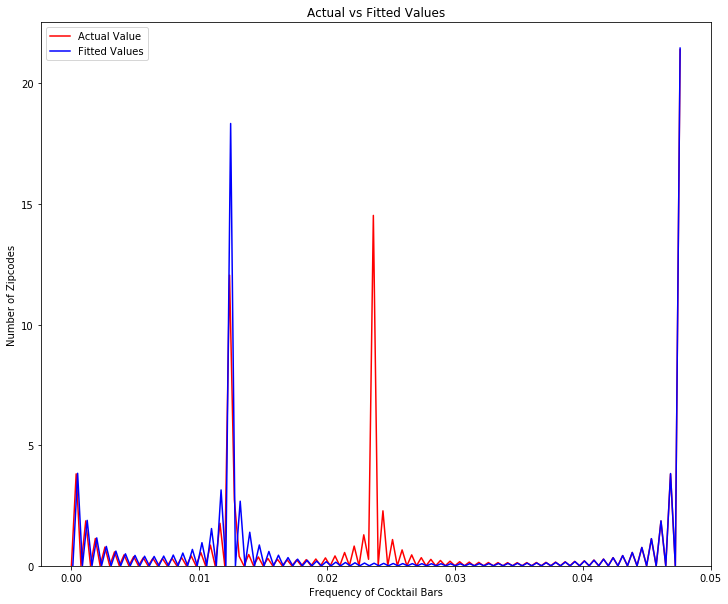

In [222]:
width = 12
height = 10
plt.figure(figsize=(width, height))


ax1 = sns.distplot(dfw_grouped['Cocktail Bar'], hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values')
plt.xlabel('Frequency of Cocktail Bars')
plt.ylabel('Number of Zipcodes')

plt.show()
plt.close()

#### Okay great! Time to split the data and train and test.

In [223]:
y_data = dfw_grouped['Cocktail Bar']

In [224]:
x_data=dfw_grouped.drop('Cocktail Bar',axis=1)

In [226]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 42
number of training samples: 166


In [227]:
lr = LinearRegression()
lr.fit(x_train[['Wine Shop', 'Chocolate Shop', 'Korean Restaurant']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [228]:
yhat_train = lr.predict(x_train[['Wine Shop', 'Chocolate Shop', 'Korean Restaurant']])
yhat_train[0:5]

array([0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426])

In [229]:
yhat_test = lr.predict(x_test[['Wine Shop', 'Chocolate Shop', 'Korean Restaurant']])
yhat_test

array([0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426,
       0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426,
       0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426,
       0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426,
       0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426,
       0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0472184,
       0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426, 0.0001426])

In [230]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [231]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Proportion of Cocktail Bars to Total Businesses')
    plt.ylabel('Number of Zipcodes a Cocktail Bar is Present')

    plt.show()
    plt.close()

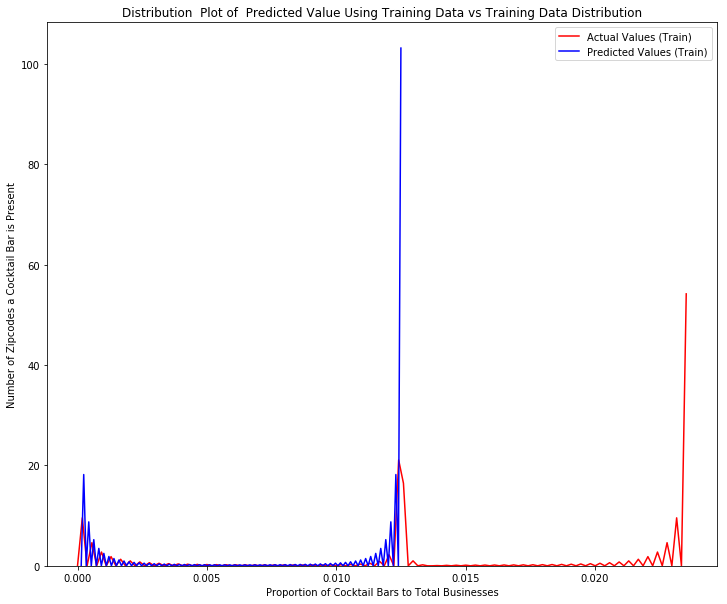

In [234]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

#### A bit odd, the prediction using the training data seems to suggest the frequency of cocktail bars is trapped at below roughly .0125. This may be an indicator we need a larger sample size. Or that there simply isn't enough cocktail bars to be able to form a meaningful prediction, let's see how the test turns out.

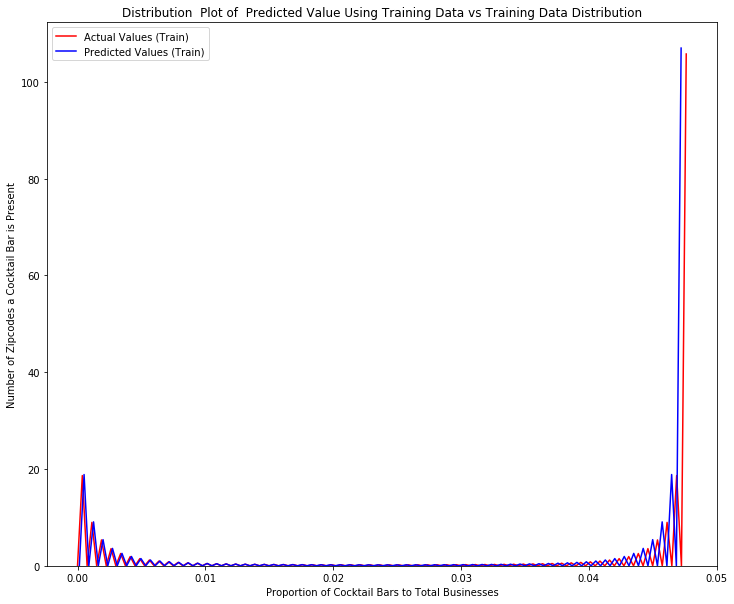

In [233]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_test, yhat_test, "Actual Values (Train)", "Predicted Values (Train)", Title)

#### The test data results look much more promising! This would suggest the predicitive model could be doing fine for the amount of data we have now. I would want to get further data from other APIs about venues, as the issue we ran into with Nightclubs has me concerned Foursquare's API could have other misleading data.